# Purpose

This notebook takes images from the training set located at http://www.cvlibs.net/datasets/kitti/eval_object.php and combines the annotations with the images, effectively drawing bounding boxes on the images.

The purpose is to see what the data looks like before we start working with it.

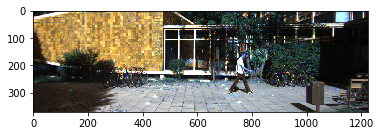

/home/ryan/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:709: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,label,a,b,c,d,bb1,bb2,bb3,bb4,a.1,a.2,a.3,a.4,a.5,a.6
0,Pedestrian,0.0,0,-0.2,712.4,143.0,810.73,307.92,1.89,0.48,1.2,1.84,1.47,8.41,0.01


In [29]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

img = cv2.imread('/home/ryan/Desktop/KITTI_Vision/data_object_image_2/training/image_2/000000.png', 1)
plt.imshow(img)
plt.show()

cols = ['label', 'a', 'b', 'c', 'd', 'bb1', 'bb2', 'bb3', 'bb4', 'a', 'a', 'a', 'a', 'a', 'a']
df = pd.read_csv('/home/ryan/Desktop/KITTI_Vision/training/label_2/000000.txt', sep='\s+', names=cols)
df